In [529]:
import numpy as np
import matplotlib.pyplot as plt

In [530]:
class Data(object):

    def __init__(self, path):
        self.dataset = self._build_dataset(path)

    @staticmethod
    def _build_dataset(path):
        structure = [('entrada', np.float),
                     ('salida', np.float)]

        with open(path, encoding="utf8") as data_csv:
            data_gen = ((float(line.split(',')[0]), float(line.split(',')[1]))
                        for i, line in enumerate(data_csv) if i != 0)
            data = np.fromiter(data_gen, structure)

        return data

    def split(self, percentage):  # 0.8
        X = self.dataset['entrada']
        y = self.dataset['salida']

        # X.shape[0] -> 10 (filas)

        permuted_idxs = np.random.permutation(X.shape[0])
        # 2,1,3,4,6,7,8,5,9,0

        train_idxs = permuted_idxs[0:int(percentage * X.shape[0])]
        # permuted_idxs[0:8]
        # [2,1,3,4,5,6,7,8,5]

        test_idxs = permuted_idxs[int(percentage * X.shape[0]): X.shape[0]]
        # [9,0]

        X_train = X[train_idxs]
        X_test = X[test_idxs]

        y_train = y[train_idxs]
        y_test = y[test_idxs]

        return X_train, X_test, y_train, y_test, X,y

In [531]:
dataset = Data(r'clase_8_dataset.csv')
X_train, X_test, y_train, y_test,X,y = dataset.split(0.8)

print(X_train.shape)


(400,)


Nube de puntos de todo el dataset


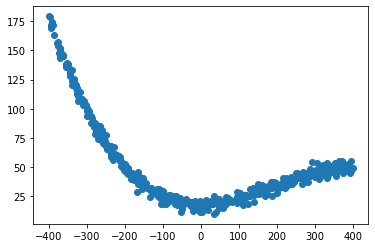

In [532]:
print("Nube de puntos de todo el dataset")
plt.scatter(X, y)

Nube de puntos del Train


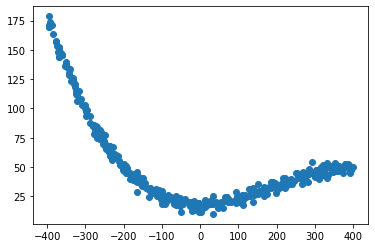

In [533]:
print("Nube de puntos del Train")
plt.scatter(X_train, y_train)

In [534]:
class Metric(object):
    def __call__(self, target, prediction):
        return NotImplemented
    
class MSE(Metric):
    def __init__(self):
        Metric.__init__(self)

    def __call__(self, target, prediction):
        n = target.size
        return np.sum((target - prediction) ** 2) / n


In [535]:
class BaseModel(object):

    def __init__(self):
        self.model = None

    def fit(self, X, Y):
        return NotImplemented

    def predict(self, X):
        return NotImplemented
    
class ConstantModel(BaseModel):

    def fit(self, X, Y):
        W = Y.mean()
        self.model = W

    def predict(self, X):
        return np.ones(len(X)) * self.model


#expandimos nuestro dataset original y le agregamos una columna de unos, lo que hacemos es que al calcular el W con la regresion afin, obtenemos la ordenada al origen
class LinearRegressionWithB(BaseModel):

    def fit(self, X, y):
        X_expanded = np.vstack((X, np.ones(len(X)))).T   #agrega una columna de unos
        W = np.linalg.inv(X_expanded.T.dot(X_expanded)).dot(X_expanded.T).dot(y)  #acá sí hace falta invertir
        self.model = W
        return W

    def predict(self, X):
        X_expanded = np.vstack((X, np.ones(len(X)))).T #la tiene que volver a expandir
        return X_expanded.dot(self.model)
    

class Quadratic_withB(BaseModel):

    def fit(self, X, y):
        X_quadratic = np.vstack((np.power(X, 2), X, np.ones(len(X)))).T   #agrega una columna de unos
        W = np.linalg.inv(X_quadratic.T.dot(X_quadratic)).dot(X_quadratic.T).dot(y)  #acá sí hace falta invertir
        self.model = W
        return W

    def predict(self, X):
        X_quadratic = np.vstack((np.power(X, 2), X, np.ones(len(X)))).T #la tiene que volver a expandir
        return X_quadratic.dot(self.model)


class Cubic_withB(BaseModel):

    def fit(self, X, y):
        X_cubic = np.vstack((np.power(X, 3),np.power(X, 2), X, np.ones(len(X)))).T   #agrega una columna de unos
        W = np.linalg.inv(X_cubic.T.dot(X_cubic)).dot(X_cubic.T).dot(y)  #acá sí hace falta invertir
        self.model = W
        return W

    def predict(self, X):
        X_cubic = np.vstack((np.power(X, 3),np.power(X, 2), X, np.ones(len(X)))).T #la tiene que volver a expandir
        return X_cubic.dot(self.model)

class Forth_withB(BaseModel):

    def fit(self, X, y):
        X_forth = np.vstack((np.power(X, 4),np.power(X, 3),np.power(X, 2), X, np.ones(len(X)))).T   #agrega una columna de unos
        W = np.linalg.inv(X_forth.T.dot(X_forth)).dot(X_forth.T).dot(y)  #acá sí hace falta invertir
        self.model = W
        return W

    def predict(self, X):
        X_forth = np.vstack((np.power(X, 4),np.power(X, 3),np.power(X, 2), X, np.ones(len(X)))).T #la tiene que volver a expandir
        return X_forth.dot(self.model)


    
    

In [536]:
l_regression_b_q = Cubic_withB()
l_regression_b_q.fit (X_train,y_train)

array([-1.01092924e-06,  6.00599934e-04,  8.58530557e-04,  1.79569173e+01])

### Ejercicio 3.a

In [537]:
def k_folds_lineal(X_train, y_train, k=5):
    l_regression_b = LinearRegressionWithB()
    error = MSE()                               #esta es la métrica que voy a usar para comparar

    chunk_size = int(len(X_train) / k)
    mse_list = []
    W = []
    min_mse = 10000
    
    for i in range(0, len(X_train), chunk_size):
        end = i + chunk_size if i + chunk_size <= len(X_train) else len(X_train)
        
        #un chunk de train va a ser de validacion
        new_X_valid = X_train[i: end]
        new_y_valid = y_train[i: end]
        
        #el resto de los chunks para entrenar
        new_X_train = np.concatenate([X_train[: i], X_train[end:]])
        new_y_train = np.concatenate([y_train[: i], y_train[end:]])

        l_regression_b.fit(new_X_train, new_y_train)
        prediction = l_regression_b.predict(new_X_valid)
        mse_list.append(error(new_y_valid, prediction))
        
        mse_actual = error(new_y_valid, prediction)
        if mse_actual < min_mse:
            min_mse = mse_actual
            W = l_regression_b.fit(new_X_train, new_y_train)

    mean_MSE = np.mean(mse_list)

    return mean_MSE,W

In [538]:
#a continuación imprimo el error cuadrático promedio de las corridas, y los valores de los parámetros que dá
#el menor MSE dentro de los 4 entrenamientos. El criterio que uso es el MSE, que sea lo menor posible.
print(k_folds_lineal(X_train,y_train))


(875.3071176750669, array([-0.0886744 , 49.86767533]))


### Ejercicio 3. b

In [539]:
def k_folds_quad(X_train, y_train, k=5):
    quadratic_withB = Quadratic_withB()
    error = MSE()                               #esta es la métrica que voy a usar para comparar

    chunk_size = int(len(X_train) / k)
    mse_list = []
    W = []
    min_mse = 10000
    for i in range(0, len(X_train), chunk_size):
        end = i + chunk_size if i + chunk_size <= len(X_train) else len(X_train)
        
        #un chunk de train va a ser de validacion
        new_X_valid = X_train[i: end]
        new_y_valid = y_train[i: end]
        
        #el resto de los chunks para entrenar
        new_X_train = np.concatenate([X_train[: i], X_train[end:]])
        new_y_train = np.concatenate([y_train[: i], y_train[end:]])

        quadratic_withB.fit(new_X_train, new_y_train)
        prediction = quadratic_withB.predict(new_X_valid)
        mse_list.append(error(new_y_valid, prediction))
        
        mse_actual = error(new_y_valid, prediction)
        if mse_actual < min_mse:
            min_mse = mse_actual
            W = quadratic_withB.fit(new_X_train, new_y_train)

    mean_MSE = np.mean(mse_list)
    #W = quadratic_withB.fit(new_X_train, new_y_train)
    
    return mean_MSE,W

In [540]:
#A CONTINUACIÓN, EL ERROR CUADRÁTICO MEDIO PARA APROXIMACION CUADRÁTIAC Y LOS PARÁMETROS CON MENOR MCE PARA DICHO MODELO
print(k_folds_quad(X_train,y_train))
mean_MSE_quadratic, w_quadratic = k_folds_quad(X_train,y_train)


#CORRO EL MEJOR MODELO DE n=2 con EL DATASET DE TEST y CALCULO EL ERROR:

X_test_quadratic = np.vstack((np.power(X_test, 2), X_test, np.ones(len(X_test)))).T
y_predict_2 = X_test_quadratic.dot(w_quadratic)
error = MSE ()
error_test = error(y_test, y_predict_2)

print('\nEl error de test para el modelo cuadrático es: ', error_test)



(101.9329559892883, array([ 5.96459178e-04, -9.39505818e-02,  1.74790828e+01]))

El error de test para el modelo cuadrático es:  99.17150706335286


In [541]:
def k_folds_cubic(X_train, y_train, k=5):
    cubic_withB =Cubic_withB()
    error = MSE()                               #esta es la métrica que voy a usar para comparar

    chunk_size = int(len(X_train) / k)
    mse_list = []
    W = []
    min_mse = 10000
    for i in range(0, len(X_train), chunk_size):
        end = i + chunk_size if i + chunk_size <= len(X_train) else len(X_train)
        
        #un chunk de train va a ser de validacion
        new_X_valid = X_train[i: end]
        new_y_valid = y_train[i: end]
        
        #el resto de los chunks para entrenar
        new_X_train = np.concatenate([X_train[: i], X_train[end:]])
        new_y_train = np.concatenate([y_train[: i], y_train[end:]])

        cubic_withB.fit(new_X_train, new_y_train)
        prediction = cubic_withB.predict(new_X_valid)
        mse_list.append(error(new_y_valid, prediction))
        
        mse_actual = error(new_y_valid, prediction)
        if mse_actual < min_mse:
            min_mse = mse_actual
            W = cubic_withB.fit(new_X_train, new_y_train)

    mean_MSE = np.mean(mse_list)
    
    return mean_MSE,W

In [542]:
#A CONTINUACIÓN, EL ERROR CUADRÁTICO MEDIO PARA APROXIMACION CUBICA Y LOS PARÁMETROS CON MENOR MCE PARA DICHO MODELO
print(k_folds_cubic(X_train,y_train))

mean_MSE_cubic, w_cubic = k_folds_cubic(X_train,y_train)


#CORRO EL MEJOR MODELO DE n=3 con EL DATASET DE TEST y CALCULO EL ERROR:

X_test_cubic = np.vstack((np.power(X_test, 3),np.power(X_test, 2), X_test, np.ones(len(X_test)))).T
y_predict_3 = X_test_cubic.dot(w_cubic)
error = MSE ()
error_test = error(y_test, y_predict_3)

print('\nEl error de test para el modelo cúbico es: ', error_test)



(9.318550238844272, array([-1.02017646e-06,  5.99249237e-04,  1.67083141e-03,  1.80148704e+01]))

El error de test para el modelo cúbico es:  10.671639680305079


In [543]:
def k_folds_forth(X_train, y_train, k=5):
    forth_withB =Forth_withB()
    error = MSE()                               #esta es la métrica que voy a usar para comparar

    chunk_size = int(len(X_train) / k)
    mse_list = []
    W = []
    min_mse = 10000
    for i in range(0, len(X_train), chunk_size):
        end = i + chunk_size if i + chunk_size <= len(X_train) else len(X_train)
        
        #un chunk de train va a ser de validacion
        new_X_valid = X_train[i: end]
        new_y_valid = y_train[i: end]
        
        #el resto de los chunks para entrenar
        new_X_train = np.concatenate([X_train[: i], X_train[end:]])
        new_y_train = np.concatenate([y_train[: i], y_train[end:]])

        forth_withB.fit(new_X_train, new_y_train)
        prediction = forth_withB.predict(new_X_valid)
        mse_list.append(error(new_y_valid, prediction))
        
        mse_actual = error(new_y_valid, prediction)
        if mse_actual < min_mse:
            min_mse = mse_actual
            W = forth_withB.fit(new_X_train, new_y_train)

    mean_MSE = np.mean(mse_list)
    
    return mean_MSE,W

In [562]:
#A CONTINUACIÓN, EL ERROR CUADRÁTICO MEDIO PARA APROXIMACION CUARTA Y LOS PARÁMETROS CON MENOS MCE PARA DICHO MODELO
print(k_folds_forth(X_train,y_train))

mean_MSE_forth, w_forth = k_folds_forth(X_train,y_train)


#CORRO EL MEJOR MODELO DE n=4 con EL DATASET DE TEST y CALCULO EL ERROR:

X_test_forth = np.vstack((np.power(X_test, 4),np.power(X_test, 3),np.power(X_test, 2), X_test, np.ones(len(X_test)))).T
y_predict_4 = X_test_forth.dot(w_forth)
error = MSE ()
error_test = error(y_test, y_predict_4)

print('\nEl error de test para el modelo con n=4 es: ', error_test)




(9.351370038398843, array([-5.47988311e-11, -1.02064226e-06,  6.06638123e-04,  1.72041442e-03,
        1.78915739e+01]))

El error de test para el modelo con n=4 es:  10.710816853463568


### Ejercicio 3.c 

#### El polinomio que hace una mejor aproximación a la nube de puntos es el de grado 4, ya que es el que menor MCE promedio presenta. 

### Ejercicio 3. d


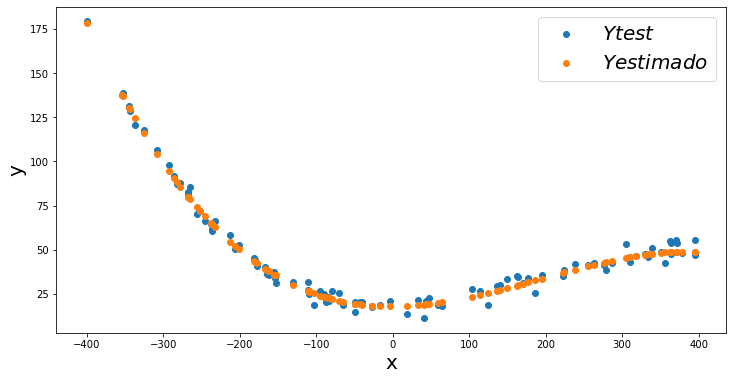

In [550]:
def plot_nube(X,y,y_predict_4):
        plt.figure(figsize=(12, 6))
        plt.scatter(X,y)
        plt.scatter (X,y_predict_4)
       
        plt.xlabel('x', size=20)
        plt.ylabel('y', size=20)
        
        plt.legend([r'$Y test$', r'$Yestimado$'], fontsize=20)
        plt.show()
        

plot_nube (X_test,y_test,y_predict_4)



### Ejercicio 4 

In [573]:
def mini_batch_gradient_descent(X_train, y_train, lr=0.5, amt_epochs=100, b=5):  #lr: learning rate
    
    """
    shapes:
        X_train = nxm
        y_train = nx1
        W = mx1
    """
    
    n = X_train.shape[0]
    m = X_train.shape[1]
    
    mse_train = MSE() 
    mse_train_list = []
    mean_MSE_train_list = []
    
    mse_val = MSE() 
    mse_val_list = []

    # initialize random weights
    W = w_forth
    print(w_forth)

    # iterate over the n_epochs
    for i in range(amt_epochs):
        
        # Shuffle all the samples 
        idx = np.random.permutation(X_train.shape[0])
        X_train = X_train[idx]
        y_train = y_train[idx]

        # Calculate the batch size in samples as a function of the number of batches
        batch_size = int(len(X_train) / b)
 
        # Iterate over the batches
        k = b
        for i in range(0, len(X_train), batch_size):
            k = k - 1
            
            end = i + batch_size if i + batch_size <= len(X_train) else len(X_train)
            batch_X = X_train[i: end] # batch_size*m
            batch_y = y_train[i: end] # batch_size*1
            batch_X_test = X_train[i: end] # batch_size*m
            batch_y_test = y_train[i: end] # batch_size*1
            

            # Calculate the prediction for the whole batch
            prediction = np.matmul(batch_X, W)  # batch_sizex1
            print (prediction)
            # Calculate the error for the whole batch
            error = batch_y - prediction  # batch_sizex1. ERROR DE TRAIN?
         
            error = np.reshape(error, (80,1))
            
            normalized_error = error/np.linalg.norm(error)
            normalized_batch_X = batch_X/np.linalg.norm(batch_X)
            
            # Calculate the gradient for the batch
            
            
            # error[batch_sizex1]*batch_X[batch_size*m]--> broadcasting --> batch_size*m
            #grad_sum = np.sum(error * batch_X, axis=0) # 1xm
            grad_sum = np.sum(normalized_error * normalized_batch_X, axis=0)
            
            
            grad_mul = -2/batch_size * grad_sum  # 1xm
            gradient = np.transpose(grad_mul)  # mx1
            
            # Update the weights
            if k > 0:
                W = W - (lr * gradient)
            
                #train error batch
                
                #batch_X_cubic = np.vstack((np.power(batch_X, 3),np.power(batch_X, 2), batch_X, np.ones(len(batch_X)))).T
                batch_y_prediction =batch_X.dot(W)
                #batch_y_prediction =batch_X_cubic.dot(W)
                mse_train_list.append (mse_train(batch_y_prediction,batch_y))
                #print(X_train)
            
            
            if k == 0:
                #validation error epoch
                #X_test_cubic = np.vstack((np.power(batch_X_test, 3),np.power(batch_X_test, 2), batch_X_test, np.ones(len(batch_X_test)))).T
                batch_y_test_prediction = batch_X_test.dot(W)
                mse_val_list.append (mse_val(batch_y_test_prediction, batch_y_test))
                
                #train error epoch
                mean_MSE_train_list.append (np.mean(mse_train_list))
                
                #agrego fila a matriz con errores de training y validacion
                errores = np.column_stack((mse_val_list, mean_MSE_train_list))
                

    return W, errores

### Ejercicio 4.a: errores de validacion (col 1) y training (col 2) para cada epoch

In [574]:
X_train_forth = np.vstack((np.power(X_train, 4),np.power(X_train, 3),np.power(X_train, 2), X_train, np.ones(len(X_train)))).T   

w_forth_gradient,errores = mini_batch_gradient_descent (X_train_forth,y_train)
print(w_forth_gradient)
#print ('Errores de validacion (col 1) y de training (col 2): \n\n', errores)



[-5.47988311e-11 -1.02064226e-06  6.06638123e-04  1.72041442e-03
  1.78915739e+01]
[ 33.25104994  22.44465545  20.38227464  24.26188362  41.87752529
  24.0138985  157.99869555  18.30441543  30.93326636  46.65735749
  18.1410462   49.01830607  41.41073355  37.11196183  48.93269334
  26.4251866   30.65710928 129.32886523  34.32701114  21.5061869
  17.92329023  48.15168448  36.31814026  18.13434906  33.85488188
  45.04515701  34.19896789  98.33726725  87.45776314  53.95871584
  48.37076587  20.40329128  25.68889241 124.60042165 115.05180013
  43.3966053   33.20602067  18.02010885  18.46122186  28.43266582
  87.52796826  75.79821142  39.01953046  69.73839746  40.95853995
  42.39112263  36.32066323 165.01238914  44.9723837   18.26341702
  28.59236328  46.86813937  30.40239038 172.66282244  67.40105044
  64.12764876  19.16297722  19.27689052  25.9299201   18.59366856
  46.01117767  24.98523051  76.42803313  34.59576329  26.58807192
  24.06369001  21.0436309   61.99674103 118.33460105  49.642

 1.47065840e+05 3.64421777e+07 1.53192196e+07 1.25633035e+08]
[7.03865102e+07 2.13843076e+08 2.22301275e+05 5.19367800e+07
 5.92429053e+06 1.22708694e+03 2.26971552e+07 7.55663321e+07
 1.36810211e+08 4.82753867e+07 2.69563368e+08 5.65518600e+07
 8.14712869e+07 2.13977149e+08 1.83022772e+01 7.58907269e+06
 1.30593078e+06 5.08572061e+07 1.68284403e+06 1.44942727e+04
 1.25557399e+07 5.79991004e+06 9.99114021e+07 4.33006493e+07
 4.72134684e+03 8.68613336e+03 1.54699420e+07 2.02887070e+08
 2.92841615e+07 7.10236341e+07 1.68611796e+08 5.47182085e+06
 2.32841992e+07 2.54647180e+07 5.24963063e+07 2.12696783e+08
 6.13177061e+06 2.58814565e+08 8.91764900e+07 1.08783674e+06
 4.41971458e+06 6.89474494e+07 2.64313666e+07 8.11418737e+04
 1.56393172e+07 2.88201433e+06 7.97209882e+07 5.35382558e+07
 1.92861188e+07 4.26108957e+07 6.23898358e+07 2.37143238e+08
 1.15185805e+07 6.14951464e+06 2.91511955e+08 3.73801419e+06
 2.91334143e+07 6.75642618e+07 1.34591475e+07 3.64421777e+07
 1.35109736e+08 5.92155

[9.08430455e+06 2.54575575e+07 1.10894643e+08 1.78916523e+01
 1.13432155e+06 4.26154559e+07 3.74620317e+04 1.23619389e+08
 1.39103171e+08 6.30391430e+07 1.31234181e+07 1.52969781e+07
 2.91368682e+07 4.28458943e+07 8.87556522e+05 3.14665013e+05
 1.77319699e+07 3.60592293e+07 1.34072137e+08 7.84150270e+05
 1.33245051e+08 3.20071181e+05 6.57803754e+03 8.69445732e+03
 6.75994468e+07 1.67673728e+05 2.74301813e+07 2.49489215e+05
 1.47134763e+05 2.65803287e+08 1.37540616e+05 3.64462458e+07
 5.80096448e+06 2.33276311e+08 9.13486148e+05 2.24779912e+08
 1.36609370e+08 2.12711400e+08 9.19511300e+04 9.89569736e+05
 2.76905082e+07 8.70611404e+05 1.10701055e+05 8.36756923e+07
 1.89584793e+05 4.23108592e+07 1.15203287e+07 1.79271842e+07
 7.55581012e+07 1.96382154e+08 4.15474346e+07 6.15602119e+07
 1.73657848e+07 9.22041449e+06 9.08966796e+05 1.03078227e+08
 1.51663491e+08 2.26938848e+07 1.74863141e+07 1.08814217e+06
 5.55861483e+07 2.73004950e+07 1.82706902e+08 8.91428042e+06
 8.36936969e+05 6.561029

### Ejercicio 4.b: gráfico de errores en función del epoch 

### Ejercicio 4.c: Comparación de los resultados obtenidos para el modelo entrenado con Mini-Batch, contra el modelo obtenido en (3c)

In [576]:
#PARA COMPARARLOS, USO EL MSE
print(w_forth)
print(w_forth_gradient)

[-5.47988311e-11 -1.02064226e-06  6.06638123e-04  1.72041442e-03
  1.78915739e+01]
[ 1.14158294e-02 -1.08874320e-04  6.06896085e-04  1.72041374e-03
  1.78915739e+01]


In [586]:
X_forth = np.vstack((np.power(X_train, 4),np.power(X_train, 3),np.power(X_train, 2), X_train, np.ones(len(X_train)))).T
y_prediction_w_original = X_forth.dot(w_forth)
y_prediction_w_gradient = X_forth.dot(w_forth_gradient)

error = MSE ()

print('MCE con w original: ', error (y_prediction_w_original,y_train))
print('MCE con w original: ', error (y_prediction_w_gradient,y_train))


MCE con w original:  9.184845420230674
MCE con w original:  8853796506254351.0
